# Surface code: any distance

In [ ]:
#export
import qsample as qs
import qiskit
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import pymatching

/Users/jhfontes/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


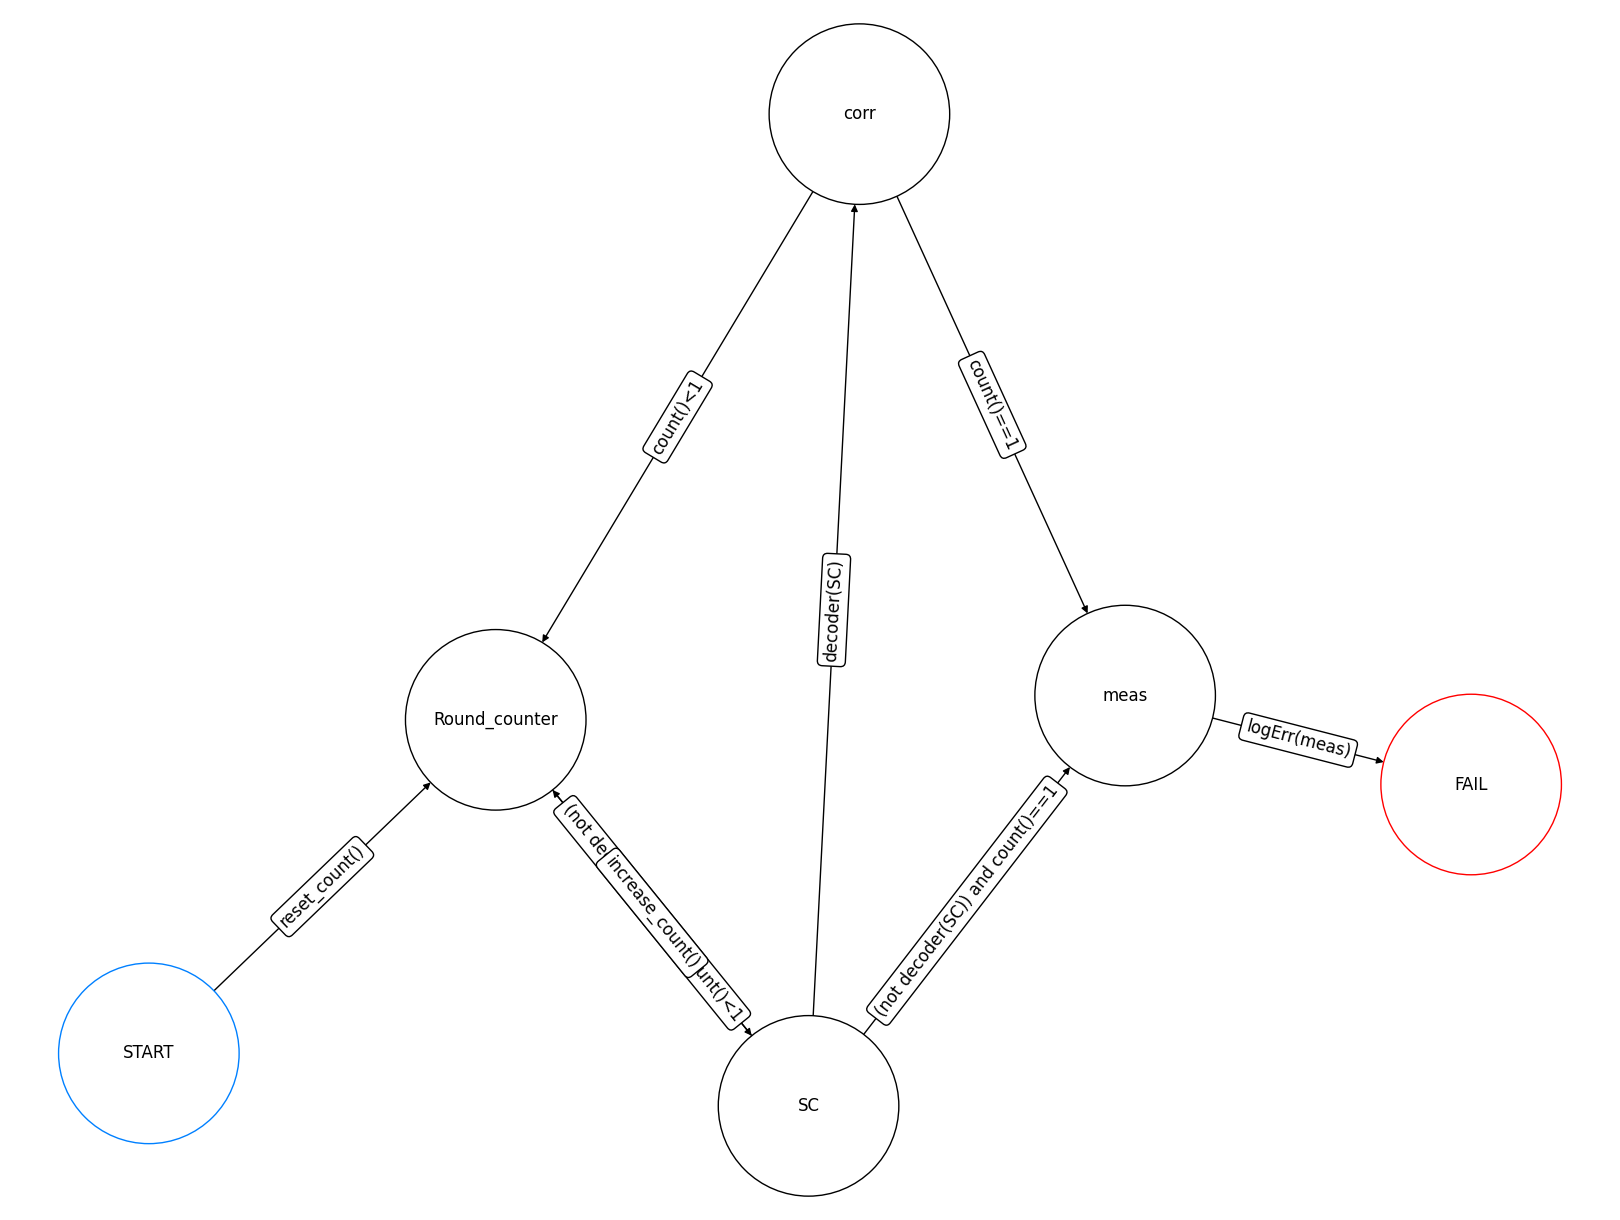

In [ ]:
distance = 3
meas_array = np.arange(distance)*(2*distance+1)+1
meas_str=""
for m in meas_array:
    meas_str+=" "
    meas_str+=str(m)

circuit = stim.Circuit.generated("surface_code:rotated_memory_x", rounds=1, distance=distance, after_clifford_depolarization=0.05,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001,)
surface_code = qs.Circuit(noisy=True).from_stim_circuit(circuit)

matching = pymatching.Matching(surface_code.dem)
num_detectors = matching.num_detectors
detector_array = surface_code.detector_array


corr = qs.Circuit(noisy=False).from_stim_circuit("""X"""+meas_str)
meas = qs.Circuit(noisy=False).from_stim_circuit("""M"""+meas_str)

round_ = 0
def reset_count():
    global round_
    round_=0
    return True

def increase_count():
    global round_
    round_+=1
    return round_

def count():
    global round_
    return round_

def int2meas(out):
    result = []
    for i in np.arange(surface_code.n_measurements)[::-1]:
        result.append(out//(2**int(i)))
        out-=result[-1]*2**int(i)
    return result

def measurement2detector(out, detector_array):
    out = int2meas(out[-1])
    detection_events = np.zeros(num_detectors)
    for ii in range(num_detectors):
        event = 0
        for jj in detector_array[ii]:
            event^=int(out[jj])
        detection_events[ii]=event
    return detection_events
    
def decoder(out):
    detection_events = measurement2detector(out, detector_array)
    result = matching.decode(detection_events)
    return result

def logErr(out):
    meas_1 = 0
    for i in range(distance):
        j = (out[0]>=(2**(distance-1-i)))
        meas_1+=j
        out[0]-=2**(distance-1-i)*j
    return meas_1%2

functions = {'decoder': decoder, 'matching':matching, 'logErr':logErr,
            'reset_count': reset_count, 'count': count, 'increase_count': increase_count}
surface = qs.Protocol(check_functions=functions)


n_rounds = 1
surface.add_nodes_from(['SC', 'corr', 'meas'], circuits=[surface_code, corr, meas])
surface.add_node('Round_counter', circuit=qs.Circuit([{"I": {0}}],noisy=False))
surface.add_edge('START', 'Round_counter', check='reset_count()')
surface.add_edge('Round_counter', 'SC', check='increase_count()')
surface.add_edge('SC', 'corr', check='decoder(SC)')
surface.add_edge('SC', 'Round_counter', check=f'(not decoder(SC)) and count()<{n_rounds}')
surface.add_edge('SC', 'meas', check=f'(not decoder(SC)) and count()=={n_rounds}')
surface.add_edge('corr', 'Round_counter', check=f'count()<{n_rounds}')
surface.add_edge('corr', 'meas', check=f'count()=={n_rounds}')
surface.add_edge('meas', 'FAIL', check='logErr(meas)')

surface.draw(figsize=(16,12))

p=('1.00e-02',): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2938.23it/s]
/Users/jhfontes/qsample/qsample/sampler/subset.py:92: RuntimeWarning: invalid value encountered in sqrt
  return np.broadcast_arrays(p_L, np.sqrt(var), p_L+delta, np.sqrt(var_up))


time: 3.4151651859283447 s


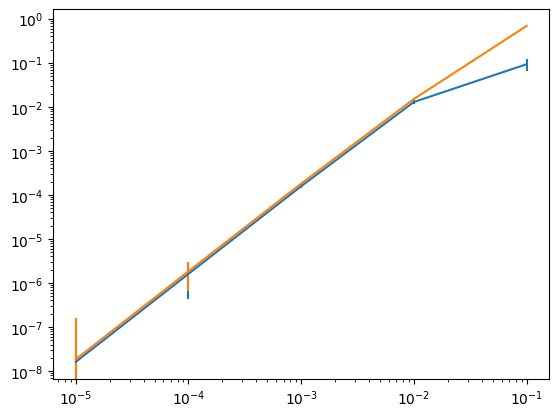

In [ ]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q}

begin = time.time()
ss_sam = qs.SubsetSampler(protocol=surface, simulator=qs.StimSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=5)
ss_sam.run(10000)
end = time.time()
qsample_time = end-begin

stats = ss_sam.stats()

plt.errorbar(q, stats[0], stats[1])
plt.errorbar(q, stats[2], stats[3])
plt.xscale('log')
plt.yscale('log')
print('time:', qsample_time, 's')